In [1]:
import glob
from Bio.SeqIO import parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
from jellyfish import hamming_distance

Prototyping error correction methods
===

Load sequence data
---

Directory containing `fastq` files:

In [2]:
data_dir = '/Users/williamdewitt/Downloads'

List of `collapse-unique.fastq` files (one per sample)

In [3]:
files = glob.glob(f'{data_dir}/*_collapse-unique.fasta')
files

['/Users/williamdewitt/Downloads/S1_collapse-unique.fasta']

Using just one sample, parse into a `pandas.DataFrame` with sequence and abundance columns

In [4]:
fasta_dat = []
for seq in parse(files[0], 'fasta'):
    cprimer, vprimer, abundance = (x.split('=')[1] for x in seq.id.split('|')[1:])
    fasta_dat.append([str(seq.seq), cprimer, vprimer, int(abundance)])
df = pd.DataFrame(fasta_dat,
                  columns=('sequence', 'C primer', 'V primer', 'abundance'))
df['length'] = df.sequence.str.len()
df

,sequence,C primer,V primer,abundance,length
0,NNNNNNNNNNNNNNNNNNNNNNNNAGTGTCTCTGGTGGCTCCGTCA...,CHG-R,IGHV4-F,1,420
1,NNNNNNNNNNNNNNNNNNNNNNNNGACATCTACGTTGATTCTTTCA...,CHG-R,IGHV4-F,1965,435
2,NNNNNNNNNNNNNNNNNNNNNNNNAGTGTCTCTGGTGCTTCCATCA...,CHG-R,IGHV4-F,1,428
3,NNNNNNNNNNNNNNNNNNNNNNNNGCTGTCTATGGTGGGTCCTTCA...,CHG-R,IGHV4-F,2037,459
4,NNNNNNNNNNNNNNNNNNNNNNNNAATGTCTCTGGTGGCGCCATCA...,CHG-R,IGHV4-F,2992,456
...,...,...,...,...,...
296894,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGGTTCACCGTCAGTAG...,CHG-R,IGHV3-F,1,428
296895,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCACCTTCAGTAA...,CHG-R,IGHV3-F,1,425
296896,NNNNNNNNNNNNNNNNNNNNNNNNACTGTCTCTGGTGGCTCCATCA...,CHG-R,IGHV4-F,1,441
296897,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCACCTTTAGCGG...,CHG-R,IGHV3-F,1,431


Abundance distribution
---

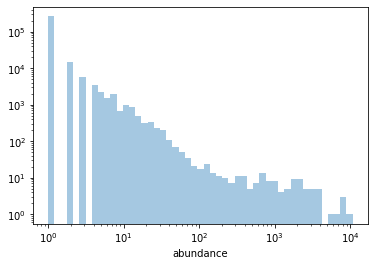

In [81]:
bins = np.logspace(0, np.log10(df.abundance.max()), 50)
sns.distplot(df.abundance, kde=False, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.show()

V primer distribution
---

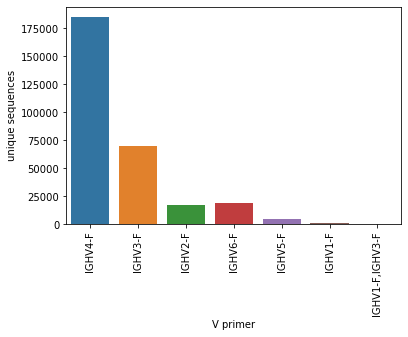

In [82]:
sns.countplot(df['V primer'])
plt.xticks(rotation='vertical')
plt.ylabel('unique sequences')
plt.show()

Length distribution
---

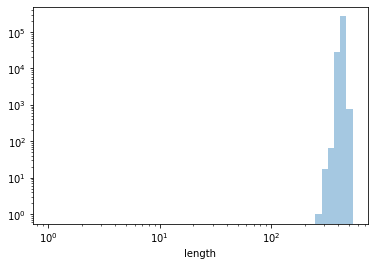

In [83]:
sns.distplot(df.length, kde=False, bins=np.logspace(0, np.log10(df.length.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.show()

Error correction based on Hamming distance and relative abundance
---

Function for computing a sparse distance matrix. The first level of sparsity is block diagonal by groups with common primers and sequence length. The second level is based on abundance ratio and hamming distance threshold.

In [113]:
def error_correct(df: pd.DataFrame,
                  distance_threshold_per_decade: np.float32 = 1) -> Tuple[np.ndarray, np.ndarray]:
    """correct errors by clustering with sparse distance computations"""
    df = df.sort_values(by=['V primer', 'C primer', 'length', 'abundance'],
                        ascending=(True, True, False, False)).reset_index(drop=True)
    assert len(df['C primer'].unique()) == 1
    
    parent_idxs = np.where(df.abundance >= 10 ** (1 / distance_threshold_per_decade))[0]

    n_clustered = 0
    
    for ct, i in enumerate(parent_idxs, 1):
        block_idxs = np.where(np.logical_and(df.length.values == df.length.values[i], df['V primer'].values == df['V primer'].values[i]))[0]
        for j in reversed(block_idxs):
            if j == i:
                break
            if df.abundance.values[i] == df.abundance.values[j] or df.abundance.values[i] == 0 or df.abundance.values[j] == 0:
                continue
            abundance_log_ratio = np.log10(df.abundance.values[i]) - np.log10(df.abundance.values[j])
            if 1 / abundance_log_ratio > distance_threshold_per_decade:
                break                
            d = hamming_distance(df.sequence.values[i], df.sequence.values[j])
            if d / abundance_log_ratio <= distance_threshold_per_decade:
                df.abundance.values[i] += df.abundance.values[j]
                df.abundance.values[j] = 0
                n_clustered += 1
        print(f'{ct / len(parent_idxs):.2%}, clustered {n_clustered}', end='    \r', flush=True)
    print()
    
    df = df[df.abundance > 0]

    return df

In [129]:
df_corrected = error_correct(df, distance_threshold_per_decade=1)
df_corrected = error_correct(df_corrected, distance_threshold_per_decade=1)
df_corrected = error_correct(df_corrected, distance_threshold_per_decade=1)

100.00%, clustered 0                   


In [130]:
df_corrected

,sequence,C primer,V primer,abundance,length
0,NNNNNNNNNNNNNNNNNNNNNNNNCCTCAGTGACGGTGTCGTGGAA...,CHG-R,IGHV1-F,1,537
1,NNNNNNNNNNNNNNNNNNNNNNNNCCTCAGTGACGGTGTCGTGGAA...,CHG-R,IGHV1-F,1,499
2,NNNNNNNNNNNNNNNNNNNNNNNNCCTCAGTGACGGTGTCGTGGAA...,CHG-R,IGHV1-F,1,492
3,NNNNNNNNNNNNNNNNNNNNNNNNCCTCAGTGACGGTGTCGTGGAA...,CHG-R,IGHV1-F,1,480
4,NNNNNNNNNNNNNNNNNNNNNNNNCCTCATTGACGGTGTCTTGGAA...,CHG-R,IGHV1-F,1,475
...,...,...,...,...,...
99899,NNNNNNNNNNNNNNNNNNNNNNNNACGGTGTCGTGGAACTCAGGCG...,CHG-R,IGHV6-F,1,348
99900,NNNNNNNNNNNNNNNNNNNNNNNNTCTCTCACAGTAACACTTTTAG...,CHG-R,IGHV6-F,1,312
99901,NNNNNNNNNNNNNNNNNNNNNNNNTCTCTCACAGTAACACTTTTAG...,CHG-R,IGHV6-F,1,312
99902,NNNNNNNNNNNNNNNNNNNNNNNNCCAAGAACGCACTGTATCTGCA...,CHG-R,IGHV6-F,1,293


Abundance distribution before and after error correction
---

unique sequences before error correction: 296899
unique sequences after error correction: 99904
singleton composition before error correction: 41.66%
singleton composition after error correction: 15.55%


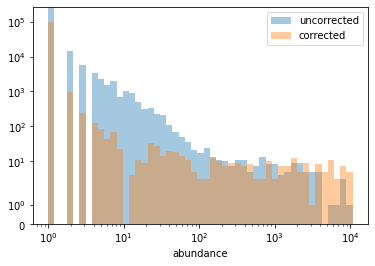

In [136]:
print(f'unique sequences before error correction: {len(df)}')
print(f'unique sequences after error correction: {len(df_corrected)}')
print(f'singleton composition before error correction: {df.abundance[df.abundance == 1].sum() / df.abundance.sum():.2%}')
print(f'singleton composition after error correction: {df_corrected.abundance[df_corrected.abundance == 1].sum() / df_corrected.abundance.sum():.2%}')
sns.distplot(df.abundance, kde=False, bins=bins, label='uncorrected')
sns.distplot(df_corrected.abundance, kde=False, bins=bins, label='corrected')
plt.xscale('log')
plt.yscale('symlog')
plt.legend()
plt.show()

In [132]:
def nearest_neighbor_distance(seq: str, seqs: np.ndarray) -> int:
    d = np.inf
    for ct, seq2 in enumerate(seqs, 1):
        if len(seq) != len(seq2):
            continue
        d_new = hamming_distance(seq, seq2)
        if 0 < d_new < d:
            d = d_new
    return d


Nearest neighbor distances of singletons Vs doubletons ...
---

In [133]:
size = 1000

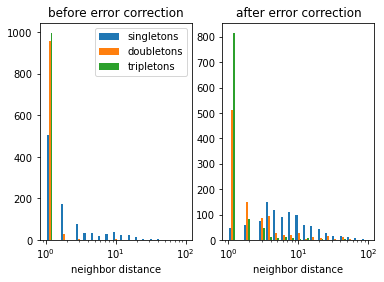

In [134]:
plt.subplot(121, title='before error correction')
plt.hist(np.array([[nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 1].values, size)],
                   [nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 2].values, size)],
                   [nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 3].values, size)]]).T,
         bins=np.logspace(0, 2, 20), label=('singletons', 'doubletons', 'tripletons'))
plt.xlabel('neighbor distance')
plt.xscale('log')
plt.legend()
plt.subplot(122, title='after error correction')
plt.hist(np.array([[nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 1].values, size)],
                   [nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 2].values, size)],
                   [nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 3].values, size)]]).T,
         bins=np.logspace(0, 2, 20), label=('singletons', 'doubletons', 'tripletons'))
plt.xlabel('neighbor distance')
plt.xscale('log')
plt.show()